In [2]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import scienceplots
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

In [3]:
#reading in data with relative paths so that it can be used by others who clone repository from github
script_dir = os.getcwd()

# the baseline were useing for treeplanting scenatio is all grass and its been extended 5km 
source_folder = os.path.abspath(os.path.join(script_dir, 'hs_files', 'July_calibrated_monthly'))

#Temperature Observations folder
observed_temp_path = os.path.abspath(os.path.join(script_dir, 'observations', 'TemperatureDataObs'))

#Temperature observations
obs = pd.read_csv(os.path.join(observed_temp_path, 'HourlySummer23Master_riverkm.csv'))

In [8]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
#obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]

In [16]:
#Fishereis focused summaries for calibrated model temperature data
modeled_tw_df = pd.read_csv(os.path.join(source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 185))
modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
modeled_tw_df.index = obs_clip.index
#mean & max july
mean_daily_modeled = modeled_tw_df.resample('D').mean()
max_daily_modeked = modeled_tw_df.resample('D').max()

mean_daily_observed = obs_clip.resample('D').mean()
max_daily_observed = obs_clip.resample('D').max()

#adding MWAT for modeled and observed temps
modeled_mwat = mean_daily_modeled.rolling(window=7).mean()
modeled_mwat = modeled_mwat.max()
modeled_mwat = pd.DataFrame(modeled_mwat)

observed_mwat = mean_daily_observed.rolling(window=7).mean()
observed_mwat = observed_mwat.max()
observed_mwat = pd.DataFrame(observed_mwat)

#adding MWMT
modeled_mwmt = max_daily_modeked.rolling(window=7).mean()
modeled_mwmt = modeled_mwmt.max()
modeled_mwmt = pd.DataFrame(modeled_mwmt)

observed_mwmt = max_daily_observed.rolling(window=7).mean()
observed_mwmt = observed_mwmt.max()
observed_mwmt = pd.DataFrame(observed_mwmt)




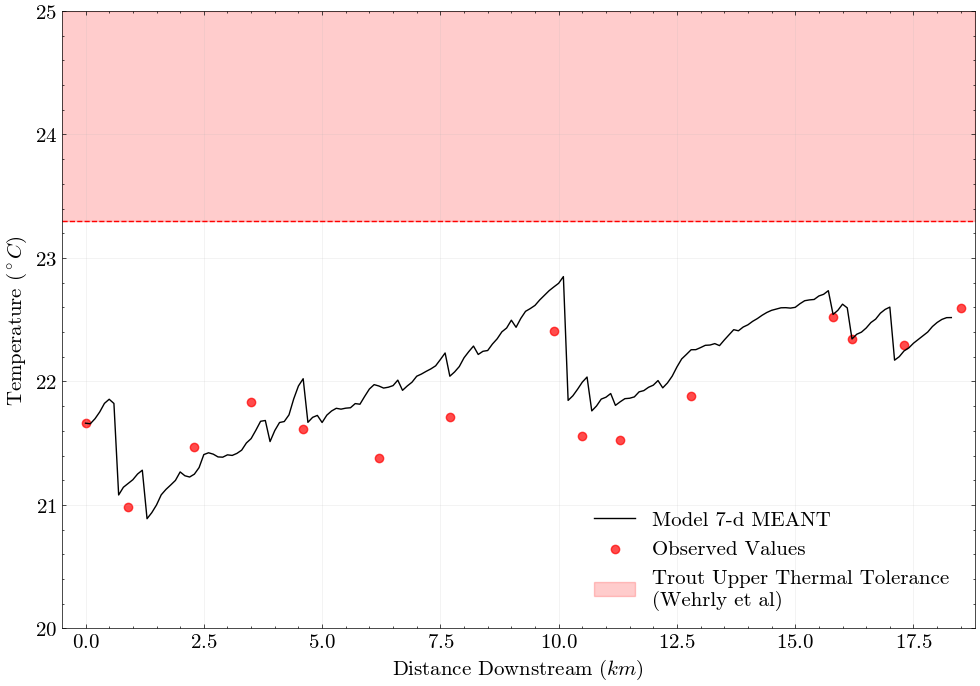

In [23]:
with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(18.5 - modeled_mwat.index, modeled_mwat[0], label='Model 7-d MEANT', color = 'black')
    #plt.plot(upstreamconstant_modeled.index/10, upstreamconstant_modeled['Mean MWAT'], label='July Max MWAT', color = 'black')

    #plt.plot(max_dailymean_scenario.index/10,max_dailymean_scenario['Max Daily Mean July Temp'],  label = 'Shade Scenario Model')
    plt.scatter(18.5-observed_mwat.index, observed_mwat[0], label = 'Observed Values', color = 'red', alpha = .7)
    #this line is just for legend item
    #p#lt.scatter(base_shade_df_mean.index/10, base_shade_df_mean['yvalue'], c='orange', s = 15, label = 'Not Shaded', marker = 's')

    #plt.scatter(base_shade_df_mean.index/10, base_shade_df_mean['yvalue'], c=base_shade_df_mean['color'], s = 15, label = 'Shaded', marker = 's')
    # plt.vlines(trib_dict_downstream,ymin = 21.5, ymax = 24.5,  label = 'Tributary', linestyles = 'dashed', alpha = .4)
    plt.axhline(y=23.3, linestyle='--', color='red')
    # plt.fill_between(upstreamconstant_modeled.index/10, upstreamconstant_modeled['Max MWAT'], y2=23.3, where=(upstreamconstant_modeled['Max MWAT'] > 23.3), color='red', alpha=0.3, label = 'Exceeding Trout Thermal Tolerance')

    # plt.fill_between((18.3 - shaded_max_mwat.index).min(), (18.3 - shaded_max_mwat.index).max(), y2=23.3, where=(shaded_max_mwat[0] > 23.3), interpolate=True, color='blue')

    # plt.fill_between(shaded_max_mwat.index, shaded_max_mwat[0], y2=23.3, where=(shaded_max_mwat > 23.3), interpolate=True, color='blue')
    x = np.linspace(-1,18.8,10)


    plt.fill_between(x,25, 23.3, color = 'red', alpha = .2, label='Trout Upper Thermal Tolerance \n(Wehrly et al)')

    plt.ylabel('Temperature (${^\circ}C$)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream ($km$)', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    plt.ylim(20, 25)
    plt.xlim(-.5, 18.8)

    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'lower right', fontsize = 15)
    plt.savefig(os.path.join(script_dir, 'Figures', 'July_MEANT_updated.png'), bbox_inches='tight', dpi=300)
    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\JulyMaxMWAT.png',bbox_inches='tight', dpi=300)
    plt.show()

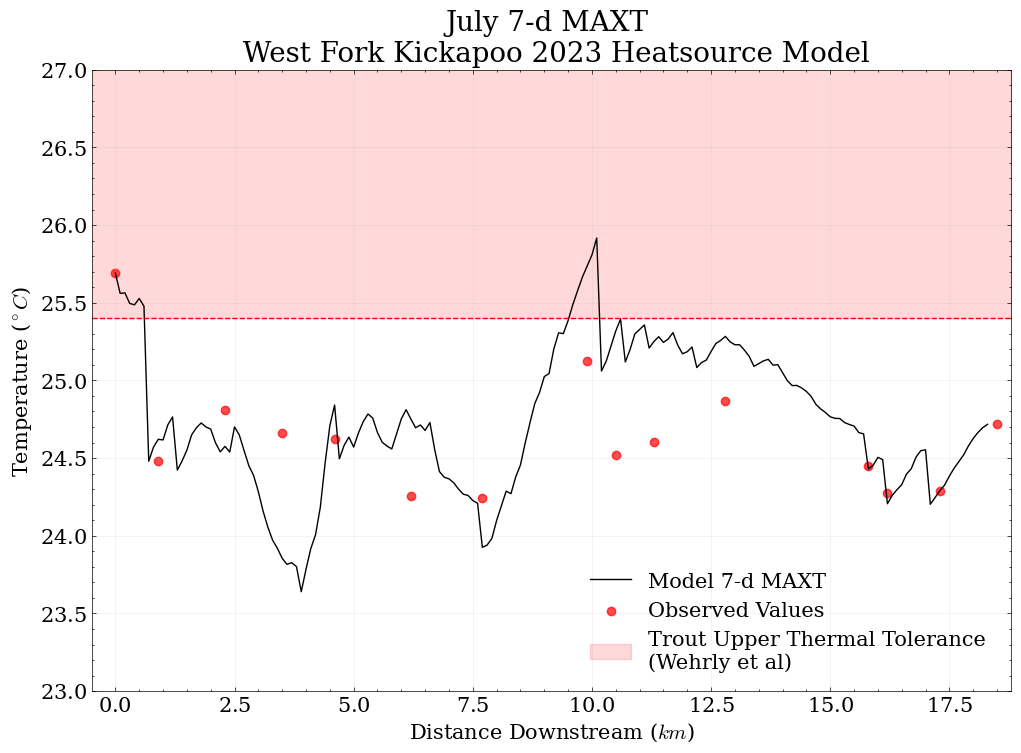

In [26]:
with plt.style.context(['science', 'no-latex']):

    plt.figure(figsize=(10, 7))
    plt.plot(18.5 - modeled_mwmt.index, modeled_mwmt[0], label='Model 7-d MAXT', color = 'black')
    plt.scatter(18.5-observed_mwmt.index, observed_mwmt[0], label = 'Observed Values', color = 'red', alpha = .7)

    #plt.plot(upstreamconstant_modeled.index/10, upstreamconstant_modeled['Mean MWAT'], label='July Max MWAT', color = 'black')

    #plt.plot(max_dailymean_scenario.index/10,max_dailymean_scenario['Max Daily Mean July Temp'],  label = 'Shade Scenario Model')
    # plt.scatter(18.3-mean_july_obs['NODE_ID'], mean_july_obs['Max MWAT'], label = 'Temp sensor', color = 'red', alpha = .7)
    #this line is just for legend item
    #p#lt.scatter(base_shade_df_mean.index/10, base_shade_df_mean['yvalue'], c='orange', s = 15, label = 'Not Shaded', marker = 's')

    #plt.scatter(base_shade_df_mean.index/10, base_shade_df_mean['yvalue'], c=base_shade_df_mean['color'], s = 15, label = 'Shaded', marker = 's')
    # plt.vlines(trib_dict_downstream,ymin = 21.5, ymax = 24.5,  label = 'Tributary', linestyles = 'dashed', alpha = .4)
    plt.axhline(y=25.4, linestyle='--', color='red')
    # plt.fill_between(upstreamconstant_modeled.index/10, upstreamconstant_modeled['Max MWAT'], y2=23.3, where=(upstreamconstant_modeled['Max MWAT'] > 23.3), color='red', alpha=0.3, label = 'Exceeding Trout Thermal Tolerance')

    # plt.fill_between((18.3 - shaded_max_mwat.index).min(), (18.3 - shaded_max_mwat.index).max(), y2=23.3, where=(shaded_max_mwat[0] > 23.3), interpolate=True, color='blue')

    # plt.fill_between(shaded_max_mwat.index, shaded_max_mwat[0], y2=23.3, where=(shaded_max_mwat > 23.3), interpolate=True, color='blue')
    x = np.linspace(-1,18.8,10)

    plt.fill_between(x,29, 25.4, color = 'red', alpha = .15, label='Trout Upper Thermal Tolerance \n(Wehrly et al)')

    plt.ylabel('Temperature (${^\circ}C$)', size = 15)
    plt.xlabel('Distance Downstream ($km$)', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    plt.ylim(23, 27)
    plt.yticks(size= 15)
    plt.xticks(size= 15)
    plt.xlim(-.5, 18.8)

    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'lower right', fontsize = 15)
    plt.title('July 7-d MAXT \n West Fork Kickapoo 2023 Heatsource Model', size = 20)
    
plt.savefig(os.path.join(script_dir, 'Figures', 'July_MAXT_updated.png'), bbox_inches='tight', dpi=300)
plt.show()
